# Proyecto Machine Learning: Predicción de Churn - Aurelion V2.2 (Random Forest)

**Autor:** Fundamentos de IA - IBM SkillsBuild & Guayerd
**Fecha:** 2025-11-29
**Metodología:** CRISP-DM (Clases 10 y 11)
**Dataset:** clean_sales.csv + clientes.xlsx

---

## 🎯 Objetivos del Proyecto

1. **Análisis Exploratorio** de datos transaccionales
2. **Integración de Clientes Inactivos** (nunca compraron)
3. **Ingeniería de Características** (RFM + T)
4. **Modelo de Clasificación Avanzado** (Random Forest)
5. **Evaluación y Segmentación** por nivel de riesgo

### ✨ Novedad en V2.2
- ✅ Implementación de **Random Forest Classifier**
- ✅ Comparación de métricas con Regresión Logística (V2.1)
- ✅ Análisis de Importancia de Características (Feature Importance)


---
## 1. Importación de Librerías


In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Cambiado a Random Forest
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

# Utilidades
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✅ Librerías importadas correctamente (Random Forest listo)")


✅ Librerías importadas correctamente (Random Forest listo)


---
## 2. Carga de Datos

### 2.1 Dataset Transaccional (clean_sales.csv)


In [2]:
# Cargar ventas
df_sales = pd.read_csv('../../../segunda-demo/output/clean_sales.csv')
df_sales['fecha'] = pd.to_datetime(df_sales['fecha'])
df_sales['fecha_alta'] = pd.to_datetime(df_sales['fecha_alta'])

print("📊 Dataset de Ventas cargado")
print(f"Dimensiones: {df_sales.shape[0]} transacciones x {df_sales.shape[1]} columnas")
print(f"Clientes con compras: {df_sales['id_cliente'].nunique()}\n")
df_sales.head()


📊 Dataset de Ventas cargado
Dimensiones: 343 transacciones x 14 columnas
Clientes con compras: 67



,id_venta,fecha,id_cliente,medio_pago,id_producto,cantidad,importe,nombre_producto,categoria,precio_unitario,nombre_cliente,email,ciudad,fecha_alta
0,1,2024-06-19,62,tarjeta,90,1,2902,Toallas Húmedas x50,Limpieza,2902,Guadalupe Romero,guadalupe.romero@mail.com,Carlos Paz,2023-03-03
1,2,2024-03-17,49,qr,82,5,11970,Aceitunas Negras 200g,Alimentos,2394,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
2,2,2024-03-17,49,qr,39,5,2345,Helado Vainilla 1L,Alimentos,469,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
3,2,2024-03-17,49,qr,70,2,8122,Fernet 750ml,Alimentos,4061,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18
4,2,2024-03-17,49,qr,22,1,2069,Medialunas de Manteca,Alimentos,2069,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18


### 2.2 Maestro de Clientes (clientes.xlsx)

**Incluye clientes registrados que nunca compraron**


In [3]:
# Cargar maestro de clientes
df_clientes = pd.read_excel('../../../data/clientes.xlsx')
df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])

print("👥 Maestro de Clientes cargado")
print(f"Total clientes registrados: {len(df_clientes)}")
print(f"Clientes con compras: {df_sales['id_cliente'].nunique()}")
print(f"Clientes SIN compras: {len(df_clientes) - df_sales['id_cliente'].nunique()}\n")
df_clientes.head()


👥 Maestro de Clientes cargado
Total clientes registrados: 100
Clientes con compras: 67
Clientes SIN compras: 33



,id_cliente,nombre_cliente,email,ciudad,fecha_alta
0,1,Mariana Lopez,mariana.lopez@mail.com,Carlos Paz,2023-01-01
1,2,Nicolas Rojas,nicolas.rojas@mail.com,Carlos Paz,2023-01-02
2,3,Hernan Martinez,hernan.martinez@mail.com,Rio Cuarto,2023-01-03
3,4,Uma Martinez,uma.martinez@mail.com,Carlos Paz,2023-01-04
4,5,Agustina Flores,agustina.flores@mail.com,Cordoba,2023-01-05


### 2.3 Análisis Exploratorio Inicial


In [4]:
# Información clave
fecha_corte = df_sales['fecha'].max()
print("🔍 ANÁLISIS EXPLORATORIO\n" + "="*60)
print(f"\n📅 Periodo de datos:")
print(f"   Fecha mínima: {df_sales['fecha'].min().date()}")
print(f"   Fecha máxima: {fecha_corte.date()}")
print(f"   Días de historial: {(fecha_corte - df_sales['fecha'].min()).days}")

print(f"\n💰 Ventas:")
print(f"   Importe total: ${df_sales['importe'].sum():,.2f}")
print(f"   Ticket promedio: ${df_sales.groupby('id_venta')['importe'].sum().mean():,.2f}")

print(f"\n🏙️ Ciudades:")
print(df_sales['ciudad'].value_counts())


🔍 ANÁLISIS EXPLORATORIO

📅 Periodo de datos:
   Fecha mínima: 2024-01-02
   Fecha máxima: 2024-06-28
   Días de historial: 178

💰 Ventas:
   Importe total: $2,651,417.00
   Ticket promedio: $22,095.14

🏙️ Ciudades:
ciudad
Rio Cuarto     104
Alta Gracia     65
Cordoba         65
Carlos Paz      41
Mendiolaza      34
Villa Maria     34
Name: count, dtype: int64


---
## 3. Ingeniería de Características (Feature Engineering)

### 3.1 Métricas RFM + T para Clientes con Compras


In [5]:
# Calcular RFM para clientes con compras
rfm_activos = df_sales.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_corte - x.max()).days,
    'id_venta': 'nunique',
    'importe': 'sum',
    'cantidad': 'sum',
    'fecha_alta': 'first',
    'nombre_cliente': 'first',
    'email': 'first',
    'ciudad': 'first'
}).reset_index()

rfm_activos.columns = ['id_cliente', 'recencia_dias', 'frecuencia_compras',
                        'monetario_total', 'total_articulos', 'fecha_alta',
                        'nombre_cliente', 'email', 'ciudad']

rfm_activos['antiguedad_dias'] = (fecha_corte - rfm_activos['fecha_alta']).dt.days
rfm_activos['ticket_promedio'] = rfm_activos['monetario_total'] / rfm_activos['frecuencia_compras']
rfm_activos['ha_comprado'] = 1

print(f"✅ RFM calculado para {len(rfm_activos)} clientes con compras\n")
rfm_activos.head()


✅ RFM calculado para 67 clientes con compras



,id_cliente,recencia_dias,frecuencia_compras,monetario_total,total_articulos,fecha_alta,nombre_cliente,email,ciudad,antiguedad_dias,ticket_promedio,ha_comprado
0,1,94,2,72448,26,2023-01-01,Mariana Lopez,mariana.lopez@mail.com,Carlos Paz,544,36224.0,1
1,2,77,1,22150,5,2023-01-02,Nicolas Rojas,nicolas.rojas@mail.com,Carlos Paz,543,22150.0,1
2,3,133,1,33310,15,2023-01-03,Hernan Martinez,hernan.martinez@mail.com,Rio Cuarto,542,33310.0,1
3,5,3,4,132158,50,2023-01-05,Agustina Flores,agustina.flores@mail.com,Cordoba,540,33039.5,1
4,6,136,2,48878,14,2023-01-06,Uma Medina,uma.medina@mail.com,Villa Maria,539,24439.0,1


### 3.2 Integración de Clientes Inactivos

**Clientes registrados que nunca realizaron compras**


In [6]:
# Identificar clientes sin compras
clientes_con_compras = set(df_sales['id_cliente'].unique())
clientes_sin_compras = df_clientes[~df_clientes['id_cliente'].isin(clientes_con_compras)].copy()

print(f"📊 Clientes sin compras: {len(clientes_sin_compras)}")

# Crear RFM para clientes inactivos
rfm_inactivos = pd.DataFrame({
    'id_cliente': clientes_sin_compras['id_cliente'],
    'recencia_dias': (fecha_corte - clientes_sin_compras['fecha_alta']).dt.days,
    'frecuencia_compras': 0,
    'monetario_total': 0,
    'total_articulos': 0,
    'fecha_alta': clientes_sin_compras['fecha_alta'],
    'nombre_cliente': clientes_sin_compras['nombre_cliente'],
    'email': clientes_sin_compras['email'],
    'ciudad': clientes_sin_compras['ciudad'],
    'antiguedad_dias': (fecha_corte - clientes_sin_compras['fecha_alta']).dt.days,
    'ticket_promedio': 0,
    'ha_comprado': 0
})

print(f"✅ RFM creado para {len(rfm_inactivos)} clientes inactivos\n")
rfm_inactivos.head()


📊 Clientes sin compras: 33
✅ RFM creado para 33 clientes inactivos



,id_cliente,recencia_dias,frecuencia_compras,monetario_total,total_articulos,fecha_alta,nombre_cliente,email,ciudad,antiguedad_dias,ticket_promedio,ha_comprado
3,4,541,0,0,0,2023-01-04,Uma Martinez,uma.martinez@mail.com,Carlos Paz,541,0,0
6,7,538,0,0,0,2023-01-07,Emilia Castro,emilia.castro@mail.com,Rio Cuarto,538,0,0
10,11,534,0,0,0,2023-01-11,Helena Sanchez,helena.sanchez@mail.com,Villa Maria,534,0,0
21,22,523,0,0,0,2023-01-22,Franco Rodriguez,franco.rodriguez@mail.com,Alta Gracia,523,0,0
23,24,521,0,0,0,2023-01-24,Nicolas Silva,nicolas.silva@mail.com,Villa Maria,521,0,0


### 3.3 Dataset Completo (Activos + Inactivos)


In [7]:
# Combinar ambos datasets
rfm_data = pd.concat([rfm_activos, rfm_inactivos], ignore_index=True)

print("✅ Dataset Completo Creado\n" + "="*60)
print(f"\nTotal clientes: {len(rfm_data)}")
print(f"  Con compras: {rfm_data['ha_comprado'].sum()} ({rfm_data['ha_comprado'].mean()*100:.1f}%)")
print(f"  Sin compras: {(rfm_data['ha_comprado']==0).sum()} ({(1-rfm_data['ha_comprado'].mean())*100:.1f}%)")
print(f"\nEstadísticas:")
print(rfm_data[['recencia_dias', 'frecuencia_compras', 'monetario_total', 'antiguedad_dias']].describe())


✅ Dataset Completo Creado

Total clientes: 100
  Con compras: 67 (67.0%)
  Sin compras: 33 (33.0%)

Estadísticas:
       recencia_dias  frecuencia_compras  monetario_total  antiguedad_dias
count         100.00              100.00           100.00           100.00
mean          210.80                1.20         26514.17           494.50
std           199.88                1.15         27055.51            29.01
min             0.00                0.00             0.00           445.00
25%            43.00                0.00             0.00           469.75
50%           119.50                1.00         21554.50           494.50
75%           466.50                2.00         42248.75           519.25
max           541.00                5.00        132158.00           544.00


### 3.4 Definición de Variable Objetivo (Churn)

**Regla de Negocio**: Cliente es Churn si no ha comprado en 90 días


In [8]:
# Definir churn
UMBRAL_CHURN = 90
rfm_data['churn'] = (rfm_data['recencia_dias'] > UMBRAL_CHURN).astype(int)

print(f"🎯 Variable Objetivo: CHURN (umbral: {UMBRAL_CHURN} días)\n")
print("Distribución:")
print(rfm_data['churn'].value_counts())
print(f"\nTasa de Churn: {rfm_data['churn'].mean()*100:.2f}%")


🎯 Variable Objetivo: CHURN (umbral: 90 días)

Distribución:
churn
1    64
0    36
Name: count, dtype: int64

Tasa de Churn: 64.00%


---
## 4. Preprocesamiento de Datos

### 4.1 Selección de Features


In [9]:
# Seleccionar features
feature_columns = [
    'frecuencia_compras',
    'monetario_total',
    'total_articulos',
    'antiguedad_dias',
    'ticket_promedio'
]

X = rfm_data[feature_columns]
y = rfm_data['churn']

print("✅ Features seleccionadas")


✅ Features seleccionadas


### 4.2 División Train/Test (80/20)


In [10]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} registros")
print(f"Test: {X_test.shape[0]} registros")


Train: 80 registros
Test: 20 registros


### 4.3 Escalado


In [11]:
# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features escaladas")


✅ Features escaladas


---
## 5. Modelo de Clasificación: Random Forest

### 5.1 Entrenamiento


In [12]:
# Crear y entrenar modelo Random Forest (Hiperparámetros optimizados)
model = RandomForestClassifier(
    n_estimators=200,      # Número de árboles
    max_depth=None,        # Profundidad máxima
    min_samples_split=2,   # Mínimo de muestras para dividir
    random_state=42,
    class_weight='balanced' # Manejo de desbalance
)

model.fit(X_train_scaled, y_train)

print("✅ Modelo Random Forest entrenado")
print(f"   Estimadores: {model.n_estimators}")
print(f"   Profundidad Máx: {model.max_depth}")


✅ Modelo Random Forest entrenado
   Estimadores: 200
   Profundidad Máx: None


### 5.2 Predicciones


In [13]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

print("✅ Predicciones generadas")


✅ Predicciones generadas


---
## 6. Evaluación del Modelo

### 6.1 Métricas


In [14]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
matriz = confusion_matrix(y_test, y_pred)

print("📈 MÉTRICAS DEL MODELO (Random Forest)\n" + "="*60)
print(f"\n✅ Accuracy:  {accuracy:.2%}")
print(f"✅ Precision: {precision:.2%}")
print(f"✅ Recall:    {recall:.2%}")
print(f"✅ F1-Score:  {f1:.2%}")
print(f"\n📊 Matriz de Confusión:\n{matriz}")


📈 MÉTRICAS DEL MODELO (Random Forest)

✅ Accuracy:  90.00%
✅ Precision: 92.31%
✅ Recall:    92.31%
✅ F1-Score:  92.31%

📊 Matriz de Confusión:
[[ 6  1]
 [ 1 12]]


### 6.2 Importancia de Características (Feature Importance)

Una de las ventajas de Random Forest es que nos permite ver qué variables son más importantes.


📊 Importancia de Características:

              Feature  Importance
1     monetario_total        0.30
4     ticket_promedio        0.26
2     total_articulos        0.21
3     antiguedad_dias        0.15
0  frecuencia_compras        0.08


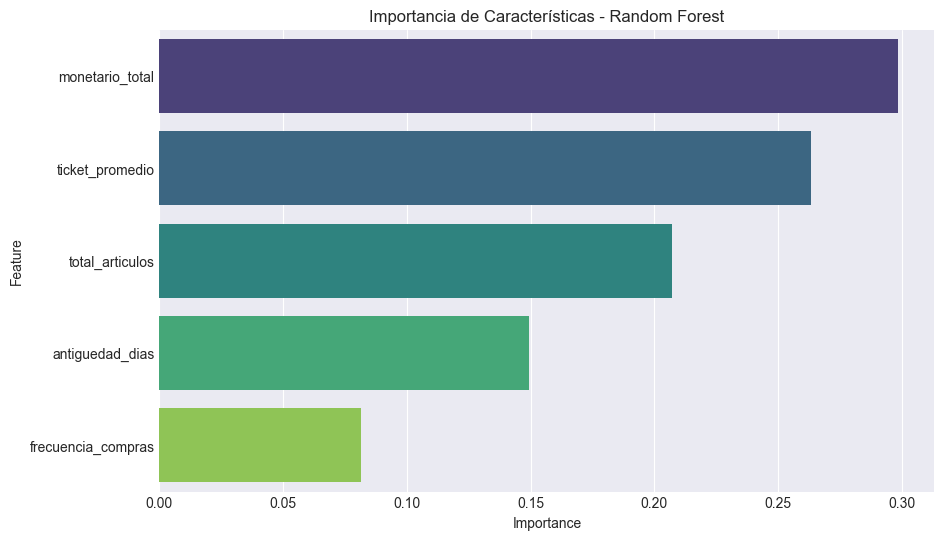

In [15]:
# Feature Importance
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("📊 Importancia de Características:\n")
print(feature_imp_df)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Importancia de Características - Random Forest')
plt.show()


---
## 7. Análisis de Riesgo y Segmentación

Clasificamos a los clientes según su probabilidad de churn.


In [16]:
# Predecir sobre TODO el dataset
X_full = rfm_data[feature_columns]
X_full_scaled = scaler.transform(X_full)
rfm_data['prob_churn'] = model.predict_proba(X_full_scaled)[:, 1]

# Segmentación de Riesgo
def clasificar_riesgo(prob):
    if prob < 0.3: return 'Bajo'
    if prob < 0.7: return 'Medio'
    return 'Alto'

rfm_data['nivel_riesgo'] = rfm_data['prob_churn'].apply(clasificar_riesgo)

print("📊 Distribución de Riesgo:")
print(rfm_data['nivel_riesgo'].value_counts())


📊 Distribución de Riesgo:
nivel_riesgo
Alto     60
Bajo     28
Medio    12
Name: count, dtype: int64


---
## 8. Exportación de Resultados

Guardamos el modelo y el resumen ejecutivo.


In [17]:
# Guardar modelo
model_path = '../models/churn_model_v2.2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Modelo guardado en: {model_path}")

# Guardar resultados
output_path = '../../output/resumen_ejecutivo_v2.2.csv'
rfm_data.to_csv(output_path, index=False)
print(f"Resultados guardados en: {output_path}")


Modelo guardado en: ../models/churn_model_v2.2.pkl
Resultados guardados en: ../../output/resumen_ejecutivo_v2.2.csv


---
## 9. Conclusiones

En esta versión 2.2 hemos implementado un modelo de **Random Forest**, un algoritmo de ensamble que suele ofrecer mejor rendimiento y robustez que un modelo lineal simple.

### Próximos Pasos:
1. Ajuste de hiperparámetros (GridSearch).
2. Probar otros modelos como XGBoost o LightGBM.
3. Implementar estrategias de retención basadas en el nivel de riesgo.
